# PyDISORT: Example calculation of VIMS spectrum
 - - - - - 

<mate@berkeley.edu>

The following notebook gives an example of how to setup the atmospheric 
structure dictionary and use it to calculate a spectrum at the VIMS 
dispersion (wavelength) scale. The `pydisort` module has been updated to include
a parallel (multiprocessing) implementation of the call to the monochromatic CDISORT
code. The requires `ipyparallel`. 
The notebook below demonstrates how to change a few of the default parameters,
run the radiative transfer calculation in either single process or multiprocessing
mode and then illustrates the comparison of the model to some VIMS observations.


### Specify data directory and download/confirm reference data

In [5]:
import numpy as np
import os
from time import time
from ipyparallel import Client

os.environ['RTDATAPATH'] = '/Users/mate/g/rt/data/refdata/'
import atmosphere as atm
from atmosphere.rt import pydisort
atm.refdata.setup_directory()

## Define methods for generating an atmospheric model of Titan and performing RT calculation

Note the parameters that are specified in the methods below. For example, the k-coefficients file,
the gas compositions, and the surface reflectivity.

In [6]:
def create_atmosphere_model(**kw):
    """
    Setup layered atmospheric model using a default physical/thermal structure
    determined by HASI, and composition from the GCMS, with aerosol 
    scattering propertier from DISR.
    
    The titan dictionary contains the values used to determine the opacity
    and scattering albedo of each atmospheric layer as a function of
    wavelength. The dispersion axis is constrained by the k-coefficients that
    are used, as specified by the methane kc_file.
    """
    
    ts = time()
    titan = atm.structure.set_HASI_structure(nlev=21,method='split_at_tropopause')
    atm.composition.set_abundances(titan, trace_gas={'m_H2':0.001})
    atm.gas_opacity.set_methane(titan, 
        kc_file='/Users/mate/g/rt/data/refdata/gas_opacity/kc_CH4.VIMS.v08.fits',
        )
    atm.gas_opacity.set_cia(titan)
    atm.aerosol.set_opacity(titan)
    DISR = atm.aerosol.fit_DISR_phases()
    atm.aerosol.set_aerosol_phase_moments(titan, DISR, nmom=32)   
    t_setup = time()-ts
    
    titan['haze'].update({'ssalb':0.96})
    titan.update({'radius':2575.,
                  'rsurf':0.10,
                  't_setup':t_setup,
                 })
    if 'rsurf' in kw: titan.update({'rsurf':kw['rsurf']})
    if 'verbose' in kw and kw['verbose']:
        pstr = 'PyDISORT Titan atmosphere structure and opacity setup: {:6.1f} sec'
        print(pstr.format(titan['t_setup']))    
    
    return titan

def setup_VIMS_calc(**kw):
    """Specify the viewing geometry and wavelegth range for the
    radiative transfer calculation."""

    titan = create_atmosphere_model(**kw)
    titan.update({'rt':{'spher':False,
                        'wav_range':(2.0,2.40),
                        'view':{'umu0':0.99,'umue': 0.90,'phi0': 10.0,'phie': 11.0},
                       }})
    for k in ['view','wav_range']: 
        if k in kw: titan['rt'].update({k:kw[k]})
            
    fi = lambda array, v: abs(array-v).argmin()
    wav_indices = lambda array, wavs: tuple([fi(array, mu) for mu in wavs])
    wav_mn, wav_mx = wav_indices(titan['wavelength'], titan['rt']['wav_range'])
    titan['rt'].update({'wav_mn':wav_mn,
                        'wav_mx':wav_mx,
                        'nlam':wav_mx-wav_mn+1,
                        })          
    return titan

In [7]:
titan = setup_VIMS_calc(wav_range=(2.0,2.10), verbose=True ) 
pydisort.calculate_spectrum(titan)
titan['rt']

PyDISORT Titan atmosphere structure and opacity setup:    1.2 sec


{'info': 'PyDISORT radiative transfer for 7 channels: 8.0 sec',
 'method': 'PyDISORT single process',
 'nlam': 7,
 'parallel': 'NOT implemented',
 'spher': False,
 't_calc': 7.991042852401733,
 'view': {'phi0': 10.0, 'phie': 11.0, 'umu0': 0.99, 'umue': 0.9},
 'wav_mn': 31,
 'wav_mx': 37,
 'wav_range': (2.0, 2.1)}

In [8]:
def spectest(model):
    for i in range(model['rt']['wav_mn'],model['rt']['wav_mx']):
        print(i, model['wavelength'][i], model['spectrum'][i])
        
spectest(titan)

31 2.00167 0.0903420410802
32 2.01781 0.108331700274
33 2.03424 0.112038196407
34 2.05091 0.10372204058
35 2.06757 0.0948675734415
36 2.084 0.0796971995697


## Parallel (multi-core) execution 
Requires `ipyparallel` and starting clusters in IPython Clusters tab of notebook to make use of multilpe cores.

In [5]:
titan = setup_VIMS_calc(wav_range=(1.5,2.25))
pydisort.cluster_spectrum_calculation(titan)
titan['rt']

{'info': 'PyDISORT parallel RT (12 processes) for 46 channels: 6.2 sec',
 'method': 'PyDISORT parallel',
 'nlam': 46,
 'parallel': 'implemented',
 'spher': False,
 't_calc': 6.181897878646851,
 'view': {'phi0': 10.0, 'phie': 11.0, 'umu0': 0.99, 'umue': 0.9},
 'wav_mn': 1,
 'wav_mx': 46,
 'wav_range': (1.5, 2.25)}

# Compare calculations with observed VIMS spectrum 

In [6]:
VIMS_test = setup_VIMS_calc(
                rsurf=0.25,
                wav_range=(1.5,3.5),
                view={'umu0':np.cos(73.13*(np.pi/180)),
                      'umue':np.cos(51.93*(np.pi/180)),
                      'phi0': 272.4,
                      'phie': 360-111.4},
                verbose=True,
                ) 
pydisort.cluster_spectrum_calculation(VIMS_test)
VIMS_test['rt']

PyDISORT Titan atmosphere structure and opacity setup:    2.2 sec


{'info': 'PyDISORT parallel RT (12 processes) for 121 channels: 15.2 sec',
 'method': 'PyDISORT parallel',
 'nlam': 121,
 'parallel': 'implemented',
 'spher': False,
 't_calc': 15.221455812454224,
 'view': {'phi0': 272.4,
  'phie': 248.6,
  'umu0': 0.29020116735122808,
  'umue': 0.61662375236365907},
 'wav_mn': 1,
 'wav_mx': 121,
 'wav_range': (1.5, 3.5)}

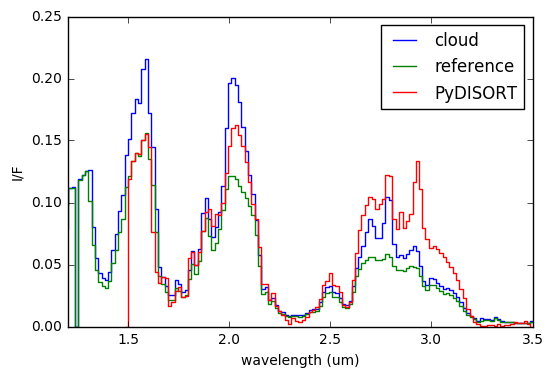

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

url = 'http://w.astro.berkeley.edu/~madamkov/refdata/test/VIMS.dat'
obs = np.genfromtxt(url,names=['wav','ref','cloud'])

fig, ax = plt.subplots()
ax.plot(obs['wav'], obs['cloud'], 'b-', drawstyle='steps-mid', label='cloud')
ax.plot(obs['wav'], obs['ref'], 'g-', drawstyle='steps-mid', label='reference')
ax.plot(VIMS_test['wavelength'], VIMS_test['spectrum'], 'r-', drawstyle='steps-mid', label='PyDISORT') 

ax.set_xlim(1.2,3.5) ;
ax.legend(loc='best')
ax.set_xlabel('wavelength (um)') ; ax.set_ylabel('I/F') ;